In [ ]:
'''
 * Copyright (c) 2008 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

## Estimating the Partition Function

As we have seen, most of the sampling algorithms considered in this chapter require only the functional form of the probability distribution up to a multiplicative constant. Specifically, if we write

$$
p_E(z) = \frac{1}{Z_E} \exp(-E(z)),
$$

where $ Z_E $ is the partition function, then the value of the normalization constant $ Z_E $ is not needed in order to draw samples from $ p(z) $. However, knowledge of the value of $ Z_E $ can be useful for Bayesian model comparison, as it represents the model evidence (i.e., the probability of the observed data given the model). Therefore, it is of interest to consider how its value might be obtained.

We assume that direct evaluation by summing, or integrating, the function $ \exp(-E(z)) $ over the state space of $ z $ is intractable. For model comparison, it is actually the ratio of the partition functions for two models that is required. Multiplying this ratio by the ratio of prior probabilities gives the ratio of posterior probabilities, which can then be used for model selection or model averaging.

### Estimating the Ratio of Partition Functions

One way to estimate the ratio of partition functions is to use importance sampling from a distribution with energy function $ G(z) $. The ratio of partition functions can be written as

$$
\frac{Z_E}{Z_G} = \frac{\int \exp(-E(z)) dz}{\int \exp(-G(z)) dz} = \frac{\langle \exp(-E(z) + G(z)) \rangle_{p_G}}{\langle \exp(-G(z)) \rangle_{p_G}},
$$

where $ \{ z^{(l)} \} $ are samples drawn from the distribution defined by $ p_G(z) $. If the distribution $ p_G $ is one for which the partition function can be evaluated analytically (e.g., a Gaussian), then the absolute value of $ Z_E $ can be obtained.

This approach will yield accurate results if the importance sampling distribution $ p_G $ is closely matched to the distribution $ p_E $, so that the ratio $ \frac{p_E(z)}{p_G(z)} $ does not have wide variations. In practice, suitable analytically specified importance sampling distributions cannot readily be found for complex models.

### Using Markov Chain to Estimate Partition Function

An alternative approach is to use the samples obtained from a Markov chain to define the importance-sampling distribution. If the transition probability for the Markov chain is given by $ T(z, z') $, and the sample set is $ \{ z^{(1)}, \ldots, z^{(L)} \} $, then the sampling distribution can be written as

$$
p_G(z) = \frac{1}{L} \sum_{l=1}^L T(z^{(l)}, z) \exp(-G(z)),
$$

which can be used directly in the ratio estimation.

### Chaining Method for Estimating Partition Functions

Methods for estimating the ratio of two partition functions require that the two corresponding distributions be reasonably closely matched. This is especially problematic if we wish to find the absolute value of the partition function for a complex distribution, because it is only for relatively simple distributions that the partition function can be evaluated directly.

This problem can be tackled using a technique known as **chaining** (Neal, 1993; Barber and Bishop, 1997), which involves introducing a succession of intermediate distributions $ p_2, \dots, p_{M-1} $ that interpolate between a simple distribution $ p_1(z) $ for which we can evaluate the normalization coefficient $ Z_1 $ and the desired complex distribution $ p_M(z) $. We then have

$$
\frac{Z_M}{Z_1} = \prod_{i=2}^{M} \frac{Z_i}{Z_{i-1}},
$$

where the intermediate ratios can be determined using Monte Carlo methods.

### Interpolating Between Distributions

One way to construct such a sequence of intermediate systems is to use an energy function containing a continuous parameter $ 0 \leq \alpha \leq 1 $ that interpolates between the two distributions:

$$
E_{\alpha}(z) = (1 - \alpha) E_1(z) + \alpha E_M(z).
$$

If the intermediate ratios are to be found using Monte Carlo, it may be more efficient to use a single Markov chain run rather than restarting the Markov chain for each ratio. In this case, the Markov chain is run initially for the system $ p_1 $, and after some suitable number of steps, it moves on to the next distribution in the sequence. Note, however, that the system must remain close to the equilibrium distribution at each stage.


In [1]:
import numpy as np

# Define the energy function for the system
def energy_function(z):
    """
    Example energy function E(z). 
    For instance, consider a quadratic potential: E(z) = z^2.
    You can modify this for a more complex system.
    """
    return 0.5 * z**2  # Simple harmonic oscillator potential

# Define the proposal distribution (e.g., a normal distribution)
def proposal_distribution(z, step_size=0.1):
    """
    Propose a new state using a random walk (normal proposal).
    """
    return z + np.random.normal(scale=step_size)

# Metropolis-Hastings update to decide whether to accept or reject the new state
def metropolis_hastings_update(z, z_new, beta=1.0):
    """
    Metropolis-Hastings acceptance criterion.
    """
    delta_H = energy_function(z_new) - energy_function(z)
    acceptance_prob = np.exp(-beta * delta_H)
    
    if np.random.rand() < acceptance_prob:
        return z_new
    else:
        return z

# Simple MCMC sampling function
def mcmc_sampling(num_samples=10000, initial_state=0, step_size=0.1, beta=1.0):
    """
    Perform MCMC to sample from the distribution.
    """
    samples = np.zeros(num_samples)
    z = initial_state
    
    for i in range(num_samples):
        z_new = proposal_distribution(z, step_size)
        z = metropolis_hastings_update(z, z_new, beta)
        samples[i] = z
        
    return samples

# Estimate the partition function Z using importance sampling
def estimate_partition_function(samples, G_func, beta=1.0):
    """
    Estimate the partition function Z using importance sampling from distribution G.
    """
    # Compute the weights based on the importance sampling ratio
    weights = np.exp(-beta * (energy_function(samples) - G_func(samples)))
    Z_estimate = np.mean(weights)
    return Z_estimate

# Example G function for importance sampling (e.g., a simple Gaussian distribution)
def G_function(z):
    """
    Example proposal energy function G(z) for importance sampling.
    Can be any distribution where Z_G can be computed analytically.
    """
    return 0.5 * z**2  # Simple Gaussian potential for G

# Main function to execute the estimation process
def main():
    # Perform MCMC sampling
    num_samples = 10000
    samples = mcmc_sampling(num_samples)
    
    # Estimate the partition function using importance sampling
    estimated_Z = estimate_partition_function(samples, G_function, beta=1.0)
    print(f"Estimated Partition Function: {estimated_Z}")

if __name__ == "__main__":
    main()


Estimated Partition Function: 1.0


Estimated Partition Function: 1.0


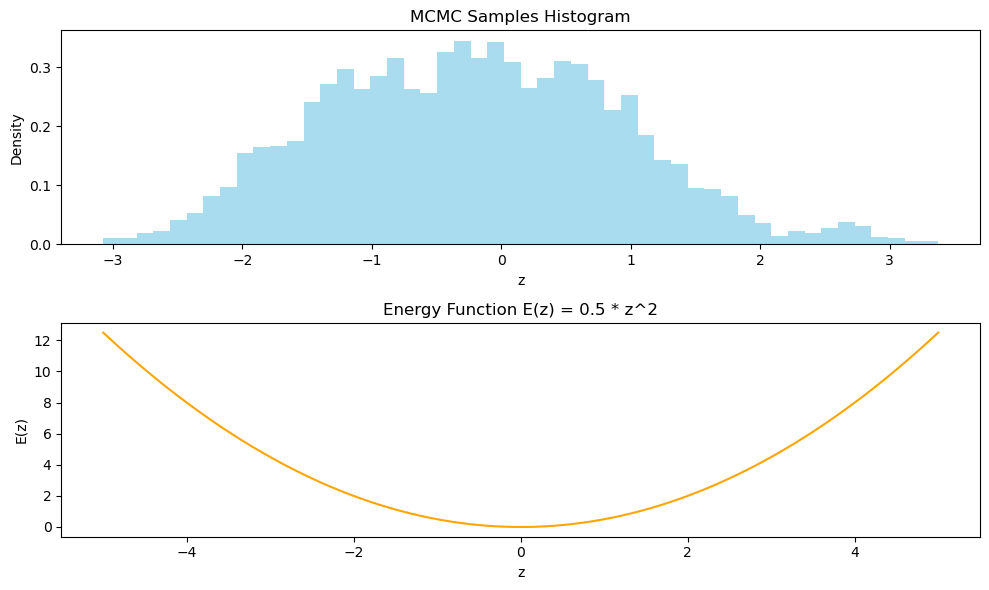

In [2]:
import random
import math
import matplotlib.pyplot as plt

# Define the energy function for the system
def energy_function(z):
    """
    Example energy function E(z). 
    For instance, consider a quadratic potential: E(z) = z^2.
    """
    return 0.5 * z**2  # Simple harmonic oscillator potential

# Define the proposal distribution (e.g., a normal distribution)
def proposal_distribution(z, step_size=0.1):
    """
    Propose a new state using a random walk (normal proposal).
    """
    return z + random.gauss(0, step_size)

# Metropolis-Hastings update to decide whether to accept or reject the new state
def metropolis_hastings_update(z, z_new, beta=1.0):
    """
    Metropolis-Hastings acceptance criterion.
    """
    delta_H = energy_function(z_new) - energy_function(z)
    acceptance_prob = math.exp(-beta * delta_H)
    
    if random.random() < acceptance_prob:
        return z_new
    else:
        return z

# Simple MCMC sampling function
def mcmc_sampling(num_samples=10000, initial_state=0, step_size=0.1, beta=1.0):
    """
    Perform MCMC to sample from the distribution.
    """
    samples = []
    z = initial_state
    
    for _ in range(num_samples):
        z_new = proposal_distribution(z, step_size)
        z = metropolis_hastings_update(z, z_new, beta)
        samples.append(z)
        
    return samples

# Estimate the partition function Z using importance sampling
def estimate_partition_function(samples, G_func, beta=1.0):
    """
    Estimate the partition function Z using importance sampling from distribution G.
    """
    # Compute the weights based on the importance sampling ratio
    weights = [math.exp(-beta * (energy_function(z) - G_func(z))) for z in samples]
    Z_estimate = sum(weights) / len(weights)
    return Z_estimate

# Example G function for importance sampling (e.g., a simple Gaussian distribution)
def G_function(z):
    """
    Example proposal energy function G(z) for importance sampling.
    Can be any distribution where Z_G can be computed analytically.
    """
    return 0.5 * z**2  # Simple Gaussian potential for G

# Main function to execute the estimation process
def main():
    # Perform MCMC sampling
    num_samples = 10000
    samples = mcmc_sampling(num_samples)
    
    # Estimate the partition function using importance sampling
    estimated_Z = estimate_partition_function(samples, G_function, beta=1.0)
    print(f"Estimated Partition Function: {estimated_Z}")
    
    # Plotting the results
    plt.figure(figsize=(10, 6))
    
    # Plot histogram of MCMC samples
    plt.subplot(2, 1, 1)
    plt.hist(samples, bins=50, density=True, color='skyblue', alpha=0.7)
    plt.title('MCMC Samples Histogram')
    plt.xlabel('z')
    plt.ylabel('Density')
    
    # Plot the energy function
    z_values = [i * 0.1 for i in range(-50, 51)]  # Values of z from -5 to 5
    energy_values = [energy_function(z) for z in z_values]
    
    plt.subplot(2, 1, 2)
    plt.plot(z_values, energy_values, color='orange')
    plt.title('Energy Function E(z) = 0.5 * z^2')
    plt.xlabel('z')
    plt.ylabel('E(z)')
    
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
